<a href="https://colab.research.google.com/github/hartwj/Lending_Club/blob/master/LendingClub2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of Lending Club Assignment 2
Assignment 1 trained a machine learning classifier to predict borrower success rates on LendingClub.com, using a set of features that were already present in the dataset. This assingment is designed to optimize the model. 



In [1]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import calendar
import itertools
from scipy import stats
from matplotlib import dates
from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Download the Data 
Keep this if you are working in Google Colab. Delete this if you are working on your own computer and have the data downloaded already. 

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3' -O lendingclub.csv

--2021-02-28 20:29:42--  https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3
Resolving docs.google.com (docs.google.com)... 108.177.127.113, 108.177.127.100, 108.177.127.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iokq925n0tfl7747c33v7rdjo9nq4i9n/1614544125000/09819396713149841370/*/0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3?e=download [following]
--2021-02-28 20:29:43--  https://doc-10-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iokq925n0tfl7747c33v7rdjo9nq4i9n/1614544125000/09819396713149841370/*/0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3?e=download
Resolving doc-10-5c-docs.googleusercontent.com (doc-10-5c-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting

**Pre-Proccessing**

In [3]:
lendingclub = pd.read_csv("lendingclub.csv")
lendingclub["Accept"] = lendingclub["outcome"] == "accept"
lendingclub["Reject"] = lendingclub["outcome"] == "reject"
lendingclub.head()

,amount,date,title,fico,dti,zip,state,emp_length,policy_code,year,outcome,Accept,Reject
0,2500.0,Dec-2011,bike,740.0,1.00,309xx,GA,< 1 year,1.0,2011,accept,True,False
1,12000.0,Dec-2011,Consolidation,675.0,10.78,913xx,CA,10+ years,1.0,2011,accept,True,False
2,21000.0,Dec-2011,Debt Cleanup,705.0,13.22,335xx,FL,10+ years,1.0,2011,accept,True,False
3,31825.0,Dec-2011,Debt Consolidation Loan,760.0,14.03,080xx,NJ,5 years,1.0,2011,accept,True,False
4,12000.0,Dec-2011,Debt Consolidation,725.0,16.70,088xx,NJ,10+ years,1.0,2011,accept,True,False


In [4]:
def employ_norm(x):
    if x == "< 1 year":
        return "short"
    if x == "2 years":
        return "short"
    if x == "3 years":
        return "short"
    if x == "4 years":
        return "medium"
    if x == "5 years":
        return "medium"
    if x == "6 years":
        return "medium"
    if x == "7 years":
        return "long"
    if x == "8 years":
        return "long"
    if x == "9 years":
        return "long"
    if x == "10+ years":
        return "long"
    
lendingclub["employ_norm"] = lendingclub["emp_length"].apply(employ_norm)
lendingclub["employ_norm"].value_counts()

short     63117
long       9086
medium     5937
Name: employ_norm, dtype: int64


# Feature Engineering

   - The `state` column is currently broken into 51 distinct values. Create a new feature, `region`, that groups similar states together.
   - The `emp_length` column is currently a nominal value. Create a new feature, `emp_length_numeric`, that treats the variable as a numeric value instead.


In [6]:
#State region variable
#This function groups states into geographic regions
#I included an NA as a check to make sures every state was being assigned
#This would allow me to spot coding errors(me) or data entry errors (lending club)
#Luckily everything was properly assigned
def region_func(value):
  if value in ("ME", "NH", "VT", "MA", "RI", "CT", "PA", "NJ", "DE","MD","NY"):
    return "NorthEast"
  if value in ("WV", "VA", "KY", "NC", "DC", "SC", "TN", "AR", "LA", "MS", "AL", "GA", "FL"):
    return "South"
  if value in ("MN", "WI", "MI", "IA", "MO", "IL", "IN", "OH"):
    return "MidWest"
  if value in ("MT", "ND", "SD", "WY", "NE", "CO", "KS"):
    return "Central"
  if value in ("AK", "HI", "CA", "OR", "WA", "ID", "NV", "UT"):
    return "West"
  if value in ("AZ", "NM", "TX", "OK"):
    return "SouthWest"
  else: 
    return "NA"

lendingclub["region"] = lendingclub["state"].apply(region_func)
lendingclub["region"].value_counts()

South        20889
NorthEast    19738
West         15732
MidWest      12454
SouthWest     9606
Central       2684
Name: region, dtype: int64

In [7]:
# Employee length numeric
# The following function involved some rounding
# <1 is now 1
# >10 is now 10
# But now everything is numeric

def employ_norm(x):
    if x == "< 1 year":
        return 1
    if x == "1 year":
        return 1
    if x == "2 years":
        return 2
    if x == "3 years":
        return 3
    if x == "4 years":
        return 4
    if x == "5 years":
        return 5
    if x == "6 years":
        return 6
    if x == "7 years":
        return 7
    if x == "8 years":
        return 8
    if x == "9 years":
        return 9
    if x == "10+ years":
        return 10
    else:
        return "NA"
    
lendingclub["emp_length_numeric"] = lendingclub["emp_length"].apply(employ_norm)
lendingclub["emp_length_numeric"].value_counts()

1     60028
10     5959
2      3362
3      2690
4      2175
5      2135
6      1627
7      1243
8      1054
9       830
Name: emp_length_numeric, dtype: int64

# Evaulting the performance of the new custom features

Keeping this simple - I'm going to use my most accurate model from assignment 1 - loan + credit decision tree. We'll be using entropy and optimizing for accuracy. 

I'll then evalue it as follows:
1. By itself
2. With State
3. With Region
4. With emp_length
5. With emp_length_numeric

In [9]:
loan_features = ["amount"]
credit_features = ["fico", "dti"]
state_features = ["state"]
region_features = ["region"]
employment_features = ["emp_length"]
employment_numeric = ["emp_length_numeric"]

feature_sets = {
    "loan and credit": loan_features + credit_features,
    "loan and credit and state": loan_features + credit_features + state_features,
    "loan and credit and region": loan_features + credit_features + region_features,
    "loan and credit and employment": loan_features + credit_features + employment_features,
    "loan and credit and employment_norm": loan_features + credit_features + employment_numeric,
}

best = 0
best_name = None

precisions = []
recalls = []
kappas = []
accuracies = []

predictions = {}
actual = None

for set_name, feature_set in feature_sets.items():

    X = lendingclub.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = lendingclub["Accept"]

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = 100*accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    metric_to_optimize = accuracy
    
    if metric_to_optimize > best:
        best = metric_to_optimize
        best_name = set_name
        
    predictions[set_name] = y_pred
    actual = np.array(list(y_test))
    
    # Bookkeeping and printing for the reader (not part of the core loop)
    print(f"Results for {set_name}:")
    print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")
    precisions.append(precision)
    recalls.append(recall)
    kappas.append(kappa)
    accuracies.append(accuracy)
    print(f"   Tree contains {model.get_n_leaves()} leaves")
    print("------------------------")

   
print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")  

Results for loan and credit:
Accuracy: 93.7 Kappa: 0.692 Precision: 0.733 Recall: 0.722
   Tree contains 3759 leaves
------------------------
Results for loan and credit and state:
Accuracy: 93.9 Kappa: 0.699 Precision: 0.736 Recall: 0.732
   Tree contains 3243 leaves
------------------------
Results for loan and credit and region:
Accuracy: 93.7 Kappa: 0.689 Precision: 0.732 Recall: 0.717
   Tree contains 3567 leaves
------------------------
Results for loan and credit and employment:
Accuracy: 94.9 Kappa: 0.748 Precision: 0.783 Recall: 0.771
   Tree contains 3066 leaves
------------------------
Results for loan and credit and employment_norm:
Accuracy: 93.4 Kappa: 0.677 Precision: 0.713 Recall: 0.716
   Tree contains 3783 leaves
------------------------
Best feature set is: loan and credit and employment 
With: 94.9% accuracy.


Looking at these results, there really is no improvement in accuracy, kappa, precision, or recall after including the new region and numerical employment features. In addition, the leaves actually increase with the new features. Intuitively this makes sense - the borrower's region should not influence the matching process. I was hoping employment length numeric would improve the model since it was now continous and not categorical i.e. the levels would improve the model. 

# Model Optimization


1. Decision tree vs. logistic regression classification.
2. Hyperparameter tuning for the best-performing model.
3. Number of folds or stratification strategy for cross-validation.



**Pre-processing**

In [11]:
# Creating a custom function to display a Confusion Matrix with Reject and Accept labels
# Define a function that takes in the predictions of a classifier, the true labels,
# and a set of metrics and displays the model's performance on the metrics
def common_evaluations(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Metrics
    conf_matrix = confusion_matrix(y_actual, y_pred)
    model_results = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_results[metric_name] = result

    # Display Metrics
    print(f"Results for {model_name}:")
    ConfusionMatrixDisplay(conf_matrix, ["Reject", "Accept"]).plot(values_format='.5g')
    plt.show()
    print(model_results)
    print("------------------------")

    return model_results

**#1 Decision Tree vs. Logistic Regression Classification**

Results for Decision Tree:


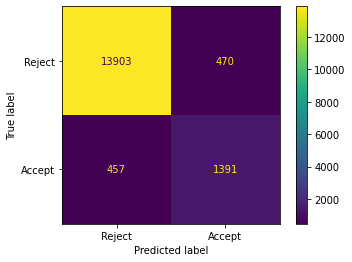

{'Accuracy': 94.28518587016829, 'Kappa': 0.7178052958676342, 'Precision': 0.7474476088124664, 'Recall': 0.7527056277056277}
------------------------
Results for Logistic Regression:


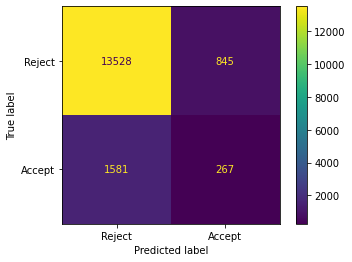

{'Accuracy': 85.04407866346094, 'Kappa': 0.10368167898621461, 'Precision': 0.24010791366906475, 'Recall': 0.1444805194805195}
------------------------
Best classifier is: Decision Tree 
With: 94.3% accuracy.


In [12]:
#Setting up two classifiers
#Optimizing for Accuracy
classifiers = {
    "Decision Tree"      : DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", max_iter=10000, random_state=123),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score,
    "Precision": precision_score,
    "Recall"   : recall_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Choose a subset of features for our dataset
# These features were chosen since they produced the highest accuracies for HW1 - they will be constant for this section
loan_features = ["amount"]
credit_features = ["fico", "dti"]
location_features = ["state"]
employment_features = ["employ_norm"]

feature_sets = {
    "loan only": loan_features,
    "credit only": credit_features,
    "loan and credit": loan_features + credit_features,
    "location only": location_features,
    "employment only": employment_features,
    "all features": loan_features + credit_features + location_features + employment_features
}

# Create our train/test split using this subset of features
# 80% training data, 20% test data
X = lendingclub.loc[:, feature_set]
y = lendingclub["Accept"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=12345)

# Create variables to keep track of our best model and the metrics for each model
best_model_metric = 0
best_model_name = None

all_model_metrics = {metric: [] for metric in metrics}

# For each model in our set of classifiers
for classifier_name, classifier in classifiers.items():

    # Train the classifier and get its predictions on the test set
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate our metrics on the data 
    model_results = common_evaluations(y_pred, y_test, metrics, classifier_name)
    
    # Update our best model if this model is better than our previous best
    comparison_metric = model_results[metric_to_optimize]
    if comparison_metric > best_model_metric:
        best_model_metric = comparison_metric
        best_model_name = classifier_name

    # Store the metrics for this model
    for metric in model_results:
        all_model_metrics[metric].append(model_results[metric]) 
    
print(f"Best classifier is: {best_model_name} \nWith: {best_model_metric:.1f}% accuracy.")  

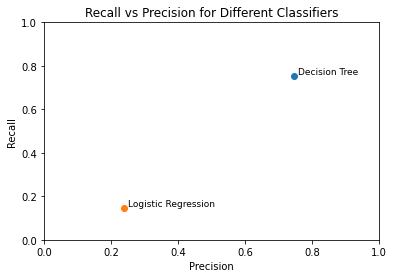

In [13]:
# Setting up a plot
plt.xlim(0,1)
plt.xlabel("Precision")
plt.ylim(0,1)
plt.ylabel("Recall")
plt.title("Recall vs Precision for Different Classifiers")

# Plot data
names = list(classifiers.keys())
for i in range(len(classifiers)):
    x = all_model_metrics['Precision'][i]
    y = all_model_metrics['Recall'][i]
    plt.scatter(x, y)
    plt.text(x+.01, y+.01, names[i], fontsize=9)

In [14]:
#The decision tree model performs much better than the logistic regression
#The accuracy is almost 10% greater, while the precision, recall, and kappa are much higher


**#2 Hyperparameter Tuning**

In [15]:
# Same feature sets from before
# Decision tree first
X = lendingclub.loc[:, feature_set]
y = lendingclub["Accept"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=12345)

# Decide on the hyperparameters we would like to compare
hyperparameters = {
    "criterion":["gini", "entropy"],
    "min_impurity_decrease":[0, 0.0001, 0.001],
    "min_samples_split":range(2, 20, 2)
}

# 5 folds for cross-validation
kfolds = 5

# Initialize a search using cross validation in sklearn
# Start with the Decision Tree Model
search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                            param_grid=hyperparameters, cv=kfolds, scoring="accuracy")

# Train a classifier with each combination of hyperparameters and take the best one
# and print out the results
classifier = search.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.1f}%")

Best fit when training was DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
With 95.2% accuracy.
Accuracy on held-out test set: 95.2%


In [16]:
#The next couple lines are creating custom functions to run the Logistic Regression Hyperparameters

In [17]:
@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UndefinedMetricWarning)
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud'):
    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = KFold(n_splits=folds, shuffle=shuffle)

    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison

In [18]:
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud'):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics


In [19]:
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud'):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, ["low traffic", "high traffic"]).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

In [20]:
# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

In [21]:
# Now trying the logistic regression model
# Here are some hyperparameters we could potentially optimize over

# Types of Regularization
cost_type = ["l1", "l2", "elasticnet", "none"]

# Types of elasticnet mix ratio
elastic_net_mixes = [0, 0.2, 0.4, 0.6, 0.8, 1]

# Strength of regularization
# Only 3 strengths since regularization model is taking too long
strengths = [0.0001, 0.01, 1]

In [22]:
# Pick Classifiers to Compare
classifiers = {
    f'Logistic Regression with C = {strength}': LogisticRegression(penalty="l1", C=strength, solver="saga", max_iter=1000, random_state=123)
    for strength in strengths
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick features to use
loan_features = ["amount"]
credit_features = ["fico", "dti"]
location_features = ["state"]
employment_features = ["employ_norm"]

feature_sets = {
    "loan only": loan_features,
    "credit only": credit_features,
    "loan and credit": loan_features + credit_features,
    "location only": location_features,
    "employment only": employment_features,
    "all features": loan_features + credit_features + location_features + employment_features
}

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, lendingclub, feature_set, "Accept", folds=3, noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.")


Logistic Regression with C = 0.0001: Fold 0...1...2
Average Accuracy: 88.601
-------------
Logistic Regression with C = 0.01: Fold 0...1...2
Average Accuracy: 88.601
-------------
Logistic Regression with C = 1: Fold 0...1...2
Average Accuracy: 88.601
-------------
Best classifier is: Logistic Regression with C = 0.01 
With: 88.6% accuracy.


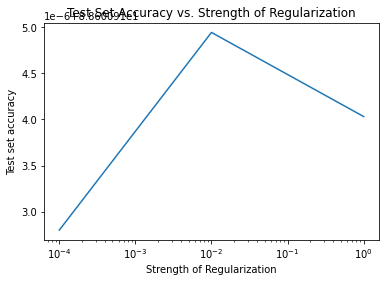

In [23]:
# Compute the average accuracy for each model
accuracies = [np.mean(classifier_comparison[classifier]['Accuracy']) for classifier in classifier_comparison]

# Plot the relation between regularization strength and accuracy
plt.title('Test Set Accuracy vs. Strength of Regularization')
plt.plot(strengths, accuracies)
plt.xlabel("Strength of Regularization")
plt.xscale("log")
plt.ylabel("Test set accuracy")
plt.show()

**#3 Number of folds or stratification strategy for cross-validation**

Can changing the numer of folds improve model accuracy?

In [24]:
# Same features as before

# Set up our dataset and cross validation split
X = lendingclub.loc[:, feature_set]
X = pd.get_dummies(X)
y = lendingclub["Accept"]

classifier = DecisionTreeClassifier(criterion="entropy", random_state=123)

num_folds = 10

accuracies = []

for i in range(num_folds):
    X_train = X.loc[X.index % num_folds != i]
    X_test = X.loc[X.index % num_folds == i]
    y_train = y.loc[y.index % num_folds != i]
    y_test = y.loc[y.index % num_folds == i]
    
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = 100*accuracy_score(y_test,y_pred)
    print(f"Fold {i}: {accuracy:.1f}% accuracy.")
    accuracies.append(accuracy)

avg_accuracy = np.mean(accuracies)
print(f"Average accuracy: {avg_accuracy:.1f}%")

Fold 0: 94.5% accuracy.
Fold 1: 94.2% accuracy.
Fold 2: 94.5% accuracy.
Fold 3: 93.6% accuracy.
Fold 4: 94.3% accuracy.
Fold 5: 94.4% accuracy.
Fold 6: 93.9% accuracy.
Fold 7: 94.1% accuracy.
Fold 8: 94.7% accuracy.
Fold 9: 94.3% accuracy.
Average accuracy: 94.2%


In [25]:
#About 10 folds produces the highest average accuracies for decision tree
#I tried decreasing and increasing folds with worse average accuracies
#Now lets see if changing the k folds improves our logsitic regression model

In [26]:
classifier = LogisticRegression(penalty="none", solver="lbfgs", max_iter=10000, random_state=123)

num_folds = 10

accuracies = []

for i in range(num_folds):
    X_train = X.loc[X.index % num_folds != i]
    X_test = X.loc[X.index % num_folds == i]
    y_train = y.loc[y.index % num_folds != i]
    y_test = y.loc[y.index % num_folds == i]
    
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = 100*accuracy_score(y_test,y_pred)
    print(f"Fold {i}: {accuracy:.1f}% accuracy.")
    accuracies.append(accuracy)

avg_accuracy = np.mean(accuracies)
print(f"Average accuracy: {avg_accuracy:.1f}%")

Fold 0: 89.2% accuracy.
Fold 1: 89.0% accuracy.
Fold 2: 89.3% accuracy.
Fold 3: 89.3% accuracy.
Fold 4: 89.1% accuracy.
Fold 5: 89.2% accuracy.
Fold 6: 89.5% accuracy.
Fold 7: 89.2% accuracy.
Fold 8: 89.4% accuracy.
Fold 9: 85.2% accuracy.
Average accuracy: 88.8%


In [27]:
#10 folds seems to be the sweet spot in achieving highest model accuracy
#By controlling folds, the accuracy increases form 85%-88%

# 4 - Fine Tuning - Train/Test Split Size

I basically ran the same code as #3 but toggled the train/test split.
By increasing test size to 30% the logistic regression accuracy improed from 85% to 89%. Kappa, precision, and recall all greatly improved as well.
Decision Tree model accuracy remained the same. Optimizing by Accuracy. 



Results for Decision Tree:


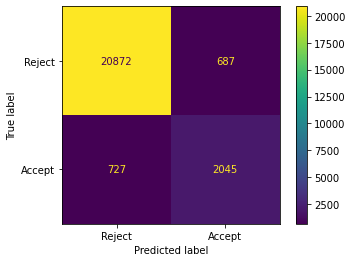

{'Accuracy': 94.1884838272163, 'Kappa': 0.7103345465973958, 'Precision': 0.7485358711566618, 'Recall': 0.7377344877344877}
------------------------
Results for Logistic Regression:


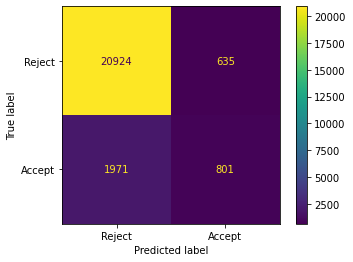

{'Accuracy': 89.28938391352595, 'Kappa': 0.3284883967222454, 'Precision': 0.557799442896936, 'Recall': 0.288961038961039}
------------------------
Best classifier is: Decision Tree 
With: 94.2% accuracy.


In [28]:
classifiers = {
    "Decision Tree"      : DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", max_iter=10000, random_state=123),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score,
    "Precision": precision_score,
    "Recall"   : recall_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Choose a subset of features for our dataset
# These features were chosen since they produced the highest accuracies for HW1 - they will be constant for this section
loan_features = ["amount"]
credit_features = ["fico", "dti"]
location_features = ["state"]
employment_features = ["employ_norm"]

feature_sets = {
    "loan only": loan_features,
    "credit only": credit_features,
    "loan and credit": loan_features + credit_features,
    "location only": location_features,
    "employment only": employment_features,
    "all features": loan_features + credit_features + location_features + employment_features
}

# Create our train/test split using this subset of features
# 70% training data, 30% test data
X = lendingclub.loc[:, feature_set]
y = lendingclub["Accept"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=12345)

# Create variables to keep track of our best model and the metrics for each model
best_model_metric = 0
best_model_name = None

all_model_metrics = {metric: [] for metric in metrics}

# For each model in our set of classifiers
for classifier_name, classifier in classifiers.items():

    # Train the classifier and get its predictions on the test set
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate our metrics on the data 
    model_results = common_evaluations(y_pred, y_test, metrics, classifier_name)
    
    # Update our best model if this model is better than our previous best
    comparison_metric = model_results[metric_to_optimize]
    if comparison_metric > best_model_metric:
        best_model_metric = comparison_metric
        best_model_name = classifier_name

    # Store the metrics for this model
    for metric in model_results:
        all_model_metrics[metric].append(model_results[metric]) 
    
print(f"Best classifier is: {best_model_name} \nWith: {best_model_metric:.1f}% accuracy.")  

# Results - Accuracy

|                     |       #1      |       #2       |    #3    |     #4     |
|---------------------|:-------------:|:--------------:|:--------:|:----------:|
|                     |   Base Model  | Hyperparamters |  K Folds | Train-test |
|                     | 80%/20% split |                | 10 Folds |   70%/30%  |
| Decision   Tree     |     94.29%    |     **95.20%**     |  94.20%  |   94.19%   |
| Logistic Regression |     85.04%    |     88.60%     |  88.80%  |   **89.29%**   |

**Ranking and Explanation**


The best model, in terms of accuracy was using a decision tree with the following hyperparameters: 

ccp_alpha=0.0, class_weight=None,criterion='entropy', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_impurity_split=None, min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best'. 
                       
This achieved an accuracy of 95% on test and training data. 

The best logistic regression model was when the test-train split was modified to 70% training, 30% test.

Overall, the decision tree models performed much better given the feature set. I believe the table above does a good job of explaining the best models in terms of ranking. 

# Review

In assignment 1, I trained a decision tree without optimizing any of the hyperparameters and resulted in a model that was 93.7% accurate on the 20% of test data. The best model from this homework, used the same feature set, decision tree, and 80%/20% train/test split and improved accuracy to 95.2% by tuning hyperparameters. 

This improvement of 1.5% is relatively small, and the model already did a good job of predicting matches. Similar to the example in assignment 1, this model would allow LendingClub to purchase loans immediately that have a high success of matching. Given loan size and volume this could result in massive short-term revenues with the improved model. 